# <center>Bibliotecas utilizadas</center>

In [1]:
from fastkan import FastKAN as KAN

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import *
from torch.utils.data import DataLoader

# <center>Pré-processamento dos dados</center>

In [2]:
train_path = 'dataset_teste2/train'
test_path = 'dataset_teste2/test'

In [3]:
#Aumentar a quantidade de técnicas de aumento de dados
transform_train = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.RandomRotation(degrees=15),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

transform_test = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
train_dataset = datasets.ImageFolder(train_path, transform = transform_train)
test_dataset = datasets.ImageFolder(test_path, transform = transform_test)

In [5]:
trainloader = DataLoader(train_dataset, batch_size = 28, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 30, shuffle = True)

# <center>Implementação da arquitetura *fastKAN*</center>

In [6]:
model = KAN([164*164*3, 164, 64, 3])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((80688,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=645504, out_features=164, bias=False)
      (base_linear): Linear(in_features=80688, out_features=164, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((164,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=1312, out_features=64, bias=False)
      (base_linear): Linear(in_features=164, out_features=64, bias=True)
    )
    (2): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=3, bias=False)
      (base_linear): Linear(in_features=64, out_features=3, bias=True)
    )
  )
)

In [7]:
num_epoch = 300
learning_rate = 0.001

In [8]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
train_acc = []

training_start_time = time.time()

for epoch in range(num_epoch):
    model.train()
    running_train_loss = 0.0

    for inputs, labels in trainloader:
        inputs = inputs.view(-1, 164*164*3).to(device)
        labels = labels.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)

    _, predicted = torch.max(outputs.data, 1)

    acc = accuracy_score(labels.cpu().detach().numpy(), predicted.cpu().detach().numpy())
    train_acc.append(acc)

    print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f} - Acurácia: {acc:.6f}")

training_time = time.time() - training_start_time
print(f"Tempo total de treinamento: {training_time:.2f} segundos")

Text(0.5, 0.98, 'Treinamento')

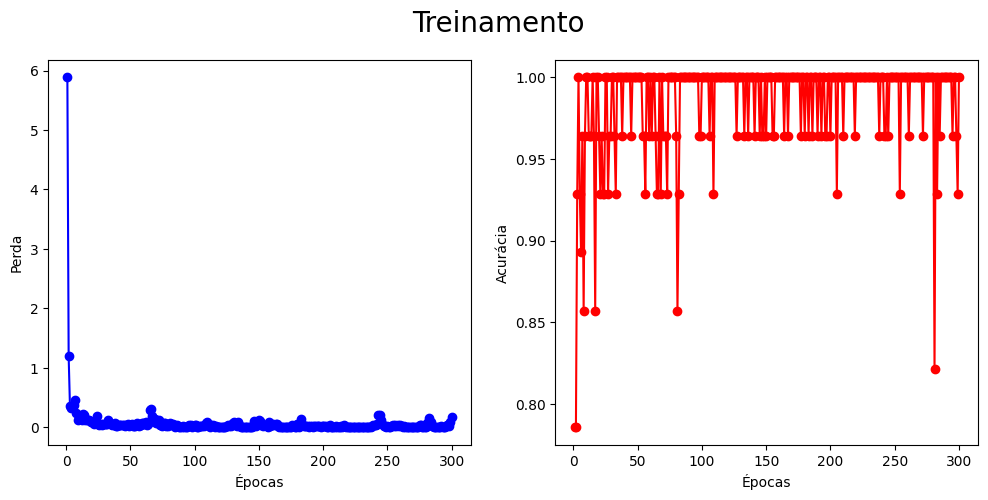

In [10]:
epochs = range(1, num_epoch + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

In [11]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in testloader:
        images = images.view(-1, 164*164*3).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())
        
print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


# <center>Métricas de avaliação</center>

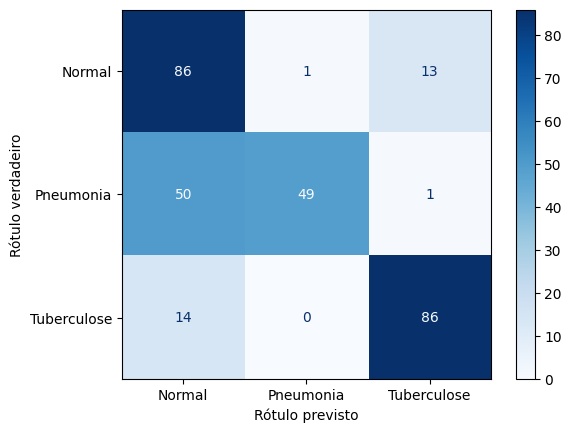

In [12]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [ ]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 73.67%


In [14]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 80.44%


In [15]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 73.67%


In [16]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 73.38%


# Observações

- Modificações realizadas: Banco de dados de 1000 imagens e Valores de batch size;

- Resultado inferior ao encontrado pelos modelos CNN e Efficient KAN;

- Tempo total de treinamento: 3158.26 segundos;

- Época 1/300 - Perda no treinamento: 5.888660 - Acurácia: 0.785714;

- Época 300/300 - Perda no treinamento: 0.172114 - Acurácia: 1.000000.